<a href="https://colab.research.google.com/github/dhguslee/Hyperparameter-Optimization/blob/main/AutoML_HPO__Theory_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Machine Learning Hyperparameter Tuning in Python**

---

[Original site (원본 사이트)](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a#4d6d)

**This paper is the document that I studied site I referred on top.**

---

## **Bayesian Optimization (by Hyperopt)**

### **● Four Part of Optimization Problem**


**1. Objective Function** \\
　: what we want to minimize, \\
　　in this cse the validation error of a ML model with respect to the  Hyperparameter


**2. Domain Sapce** \\
　: Hyperparameter values to search over


**3. Optimization algorithm** \\
　: Method of constructing the surrogate model and choosing the next hyperparameter values to evaluate


**4. Result history** \\
　: Stored outcomes from evaluations of the objective function consisting of the hyperparameters and validation loss 

In [23]:
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold

### **● Data set**


Caravan Insurance dataset
- Objective :  predict whethera customer will purchase an insurance policy.

- Supervised classcification problem with 5800 training and 4000 testing points.

- Imbalanced classification problem

- Assess performance : ROC AUC(Receiver Operating Characteristic Area Under the Curve) \\
　　　　　　　　　　Hyperopt requires a value to minimize, so 1 - ROC

- CARAVAN : 0 (not bought)  ,   1 (bought)

In [24]:
# Read Data an Separate into training and testing sets

data = pd.read_csv("drive/MyDrive/Data set/caravan-insurance-challenge.csv")

train = data[data["ORIGIN"] == "train"]
test = data[data["ORIGIN"] == "test"]


# Extract the labels an format properly

train_labels = np.array(train["CARAVAN"].astype(np.int32)).reshape((-1,))
test_labels = np.array(test["CARAVAN"].astype(np.int32)).reshape((-1,))


# Drop the unneeded columns

train = train.drop(columns = ["ORIGIN", "CARAVAN"])
test = test.drop(columns = ["ORIGIN", "CARAVAN"])


# Convert to numpy array for splitting in cross validation

features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]


print("Train shape : ", train.shape)
print("Test shape : ", test.shape)
train.head()

Train shape :  (5822, 85)
Test shape :  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


**Distribution of Label**

Text(0.5, 1.0, 'Counts of Labels')

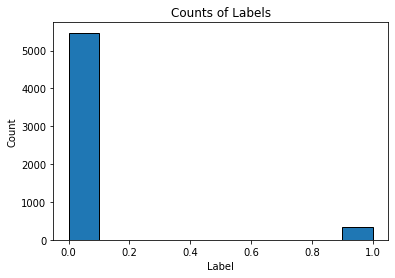

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(labels, edgecolor = "k")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Counts of Labels")

### **● Gradient Boosting Model**

- Thw GBM is an ensemble boosing method based on using weak learners (almost always decision trees) \\
trained sequentially to form a strong model.

- There are many Hyperparameters in a GBM controlling both the entire ensemble and individual decision trees.


- One of the most effective methods for choosing the number of trees (called estimator) \\
is early stopping

- "LightGBM" provides a fast and simple implementation of the GBM in Python

In [26]:
# Model with default Hyperparmeter

model = lgb.LGBMClassifier()
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [27]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[ : , 1]  # ; predictions 
auc = roc_auc_score(test_labels, predictions)

print("The baseline score on the test set is {: .4f}.".format(auc))
print("The baseline training time is {: 4f} seconds.".format(train_time))

The baseline score on the test set is  0.7092.
The baseline training time is  0.312958 seconds.


### **1. Objective Function**

- The objective function is what we are trying to minimize. 

- It takes in a set of values — in this case hyperparameters for the GBM \\
— and outputs a real value to minimize — the cross validation loss. 

- Hyperopt treats the objective function as a black box because it only considers what goes in and what comes out. 

- The complete objective function for the Gradient Boosting Machine \\
using 10 fold cross validation with early stopping is shown below.

In [28]:
import lightgbm as lgb
from hyperopt import STATUS_OK

N_FOLDS = 10

# Create the dataset

train_set = lgb.Dataset(features, train_labels)

def objective(params, n_folds = N_FOLDS) :
  """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""

  # Perform n_fold cross validation with hyperparamters
  # Use early stopping and evalute base on ROC AUC
  cv_result = lgb.cv(params, 
                     train_set, 
                     nfold = n_folds, 
                     num_boost_round = 10000,
                     early_stopping_rounds = 100, 
                     metrics = "auc", 
                     seed = 50)
  
  # Extract the best score
  best_score = max(cv_result["auc-mean"])

  # Loss must be minimized
  loss = 1 - best_score

  # Dictionary with information for evaluation
  return {"loss" : loss, "params" : params, "status" : STATUS_OK}   # If the status is STATUS_OK, 
                                                                    # then the loss must be the objective function value for the trial.

### **2. Domain Space**


- It represents the range of values we want to evaluate for each hyperparameter.

- The domain space is a grid, when we do random or grid search.

- The domain space has Probability distribution, when we do Bayesian optimization.

- It is the trickiest part of a Bayesian Opimization problem.

#### **- First, we should look at all the hyperparameter in a GBM**

- I am not sure there’s anyone in the world who knows how all of these interact together! 

- Some of these we don’t have to tune (such as objective and random_state ) \\
and we will use early stopping to find the best n_estimators. 



In [29]:
import lightgbm as lgb

# Default gradient boosting machine classifier

model = lgb.LGBMClassifier()
model

"""
LGBMClassifier(boosting_type = "gbdt",
               n_estimators = 100,
               class_weight = None,
               colsample_bytree = 1.0,
               learning_rate = 0.1,
               max_depth = -1,
               min_child_samples = 20,
               min_child_weight = 0.001,
               min_split_gain = 0.0,
               n_jobs = -1,
               num_leaves = 31,
               objective = None,
               random_state = None,
               reg_alpha = 0.0,
               reg_lambda = 0.0,
               silent = True, 
               subsample = 1.0,
               subsample_for_bin = 200000,
               subsample_freq = 1)
"""

'\nLGBMClassifier(boosting_type = "gbdt",\n               n_estimators = 100,\n               class_weight = None,\n               colsample_bytree = 1.0,\n               learning_rate = 0.1,\n               max_depth = -1,\n               min_child_samples = 20,\n               min_child_weight = 0.001,\n               min_split_gain = 0.0,\n               n_jobs = -1,\n               num_leaves = 31,\n               objective = None,\n               random_state = None,\n               reg_alpha = 0.0,\n               reg_lambda = 0.0,\n               silent = True, \n               subsample = 1.0,\n               subsample_for_bin = 200000,\n               subsample_freq = 1)\n'

#### **- The number of leaves in each tree in the GBM**

- When first tuning a model, I usually create a wide domain space centered around the default values and then refine it in subsequent searches.

- As an example, let’s define a simple domain in Hyperopt, \\
a discrete uniform distribution for the number of leaves in each tree in the GBM

- This is a discrete uniform distribution \\
because the number of leaves must be an integer (discrete) and each value in the domain is equally likely (uniform).

In [30]:
from hyperopt import hp

# Discrete uniform distribution
num_leaves = {"num_leaves" : hp.quniform("num_leaves", 30, 150, 1)}

#### **- Another choice of distribution** 

- It is the log uniform which distributes values evenly on a logarithmic scale.

- We will use a log uniform (from 0.005 to 0.2) for the learning rate \\
because it varies across several orders of magnitude

- Because this is a log-uniform distribution, the values are drawn between exp(low) and exp(high). 

In [31]:
from hyperopt import hp

# Learning rate log uniform distribution
learning_rate = {"learning_rate" : hp.loguniform("learning_rate", np.log(0.005), np.log(0.2))}

#### **- PLOT**

- The plot on the left is the discrete uniform distribution.

- The plot on the right is the log uniform. 

- These are kernel density estimate plots so the y-axis is density and not a count!

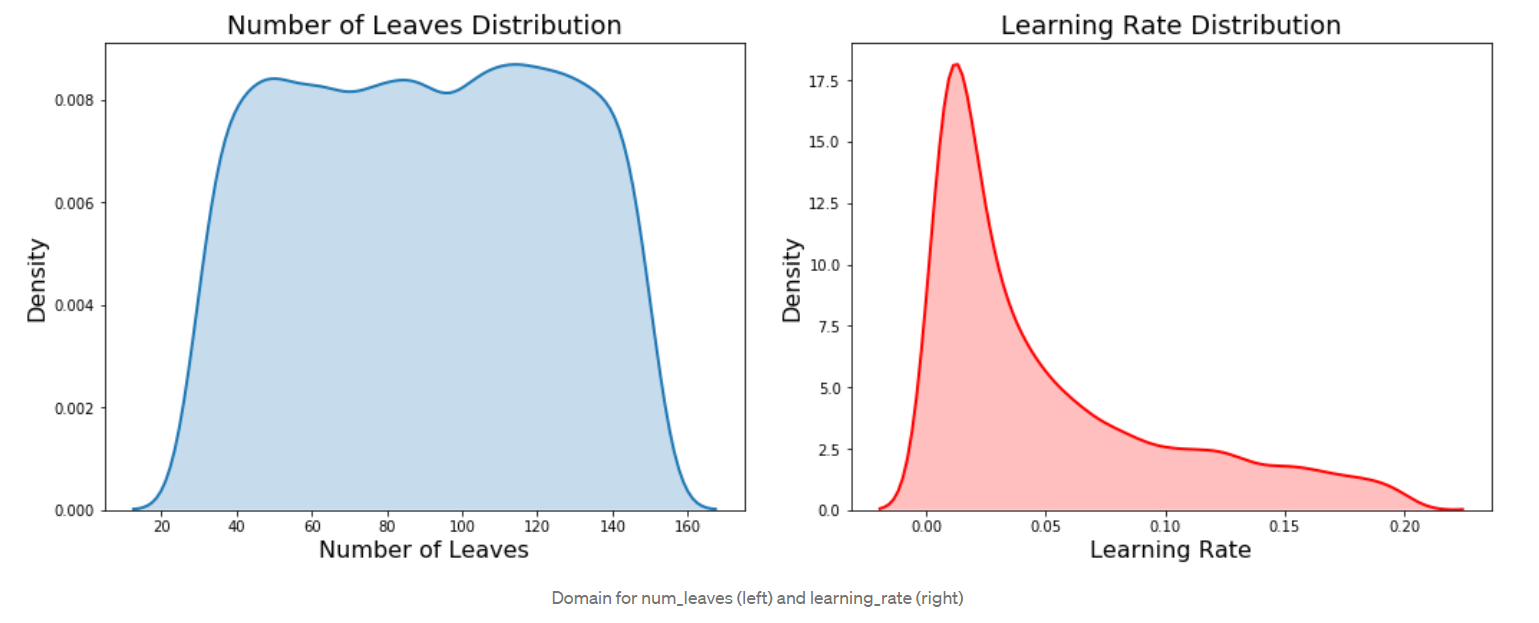

#### **- Let's define the entrie domain**

- choice : categorical variables

- quniform : discrete uniform (integers spaced evenly)

- uniform: continuous uniform (floats spaced evenly)

- loguniform: continuous log uniform (floats spaced evenly on a log scale)

In [32]:
# Define the search space

space = {
        'class_weight': hp.choice('class_weight', [None, 'balanced']),
        
        'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 
                                                      'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                     {'boosting_type': 'dart', 
                                                       'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                     {'boosting_type': 'goss'}
                                                    ]),
        
        'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
        
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        
        'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
        
        'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
        
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        
        'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

#### **- One important point**

- Here we are using a conditional domain \\
which means the value of one hyperparameter depends on the value of another. 

- For the boosting type "goss",  the gbm cannot use subsampling \\
(selecting only a "subsample" fraction of the training observations to use on each iteration). 

- The "subsample" ratio is set to 1.0 (no subsampling) if the boosting type is "goss" but is 0.5–1.0 otherwise. \\
This is implemented using a nested domain.

- Conditional nesting can be useful when we are using different machine learning models with completely separate parameters. 

- A conditional lets us use different sets of hyperparameters depending on the value of a "choice".

In [33]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type',  [{'boosting_type': 'gbdt', 
                                                                'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             
                                                               {'boosting_type': 'dart', 
                                                                'subsample': hp.uniform('subsample', 0.5, 1)},
                                                              
                                                               {'boosting_type': 'goss',
                                                                'subsample': 1.0}
                                                               ])
                }

#### **- One example**

- Now that our domain is defined, \\
we can draw one example from it to see what a typical sample looks like. 

- When we sample, we need to assign it to a top-level key \\
because "subsample" is initially nested.

- This is done using the Python dictionary "get" method with a default value of 1.0.


- This reassigning of nested keys is necessary \\
because the gradient boosting machine cannot deal with nested hyperparameter dictionaries.


In [34]:
from hyperopt.pyll.stochastic import sample

# Sample from the full space
example = sample(space)

# Dictionary get method with default
subsample = example['boosting_type'].get('subsample', 1.0)

# Assign top-level keys
example['boosting_type'] = example['boosting_type']['boosting_type']
example['subsample'] = subsample

example

{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 0.9393524936400368,
 'learning_rate': 0.1496648116967781,
 'min_child_samples': 255.0,
 'num_leaves': 128.0,
 'reg_alpha': 0.07541843881538701,
 'reg_lambda': 0.04369506916004118,
 'subsample': 1.0,
 'subsample_for_bin': 160000.0}

### **3. Optimization Algorithm**


- It is the most conceptually difficult part of Bayesian

- Use the Tree Parzen Estimator(= [TPE](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf))

- TPE $\ $:$\ $  During optimization, It constructs the probaboloty model from the past results \
　　　and decides the next set of hyperparameters to evaluate in the objective function \
　　　by maximizing the expected improvement.



In [35]:
from hyperopt import tpe

# Algorithm
tpe_algorithm = tpe.suggest

### **4. Result History**

- Keeping track of the results,  It is not strictly necessary.

- but If you want to find out it, we can use a Trial object.

- It has informations about basic training information \
and the dictionary returned from the objective function includes the los an params.

- Writing to a csv means we can check the progress by opening the file while training \
(although not in Excel because this will cause an error in Python. \
$\ $Use tail out_file.csv from bash to view the last rows of the file).

In [36]:
from hyperopt import Trials

# Trials object to track progress
bayes_trials = Trials()

- we can save all the results to disk in case something catastrophic happens

- we can do this using the "csv" library

- It is to write a line a csv file with each search iteration.

In [37]:
import csv

# File to save first results
out_file  = "drive/MyDrive/Data set/gbm_trials.csv"
of_connection = open(out_file, "w")
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(["loss","params","iteration","estimator","train_time"])
of_connection.close()

In [38]:
# Write to the csv file ("a" emans append)
"""
of_connection = open(out_file, "a")
writer = csv.writer(of_connection)
writer.writerow([loss, params, iteration, n_estimators, run_time])
of_connection.close()
"""

'\nof_connection = open(out_file, "a")\nwriter = csv.writer(of_connection)\nwriter.writerow([loss, params, iteration, n_estimators, run_time])\nof_connection.close()\n'

### **● Optimization**

- We have the four parts in place, optimization is run with ["fmin"](https://github.com/hyperopt/hyperopt/wiki/FMin)

- Each iteration, the algorithm chooses new hyperparameter values from the surrogate function \
which is constructed based on the previous results and evaluates these values in the objective function. 

In [ ]:
from hyperopt import fmin

MAX_EVALS = 500

# Optimize
best = fmin(fn = objective,           # gmb + cross validataion
            space = space,            # domain space
            algo = tpe.suggest,       # optmization algorithm
            max_evals = MAX_EVALS,    # iterations
            trials = bayes_trials)    # Result histroy

### **● Results**

#### **- Trainin results**

'boosting_type': 'gbdt',
   
'class_weight': 'balanced',

'colsample_bytree': 0.7125187075392453,

'learning_rate': 0.022592570862044956,

'min_child_samples': 250,

'num_leaves': 49,

'reg_alpha': 0.2035211643104735,

'reg_lambda': 0.6455131715928091,

'subsample': 0.983566228071919,

'subsample_for_bin': 200000

---

The best model scores 0.72506 AUC ROC on the test set.

The best cross validation score was 0.77101 AUC ROC.

This was achieved after 413 search iterations.

#### **- Important notes**

- The optimal hyperparameters are those that do best in cross validation \
and not necessarily those that do best on the testing data. \
When we use cross validation, we hope that these results generalize to the testing data.

- Even using 10-fold cross-validation, the hyperparameter tuning overfits to the training data. \
The best score from cross-validation is significantly higher than that on the testing data.

- Random search may return better hyperparameters just by sheer luck\
(re-running the notebook can change the results).\
Bayesian optimization is not guaranteed to find better hyperparameters \
and can get stuck in a local minimum of the objective function.

#### **- Bayesian Optimization Limitation**


- Limitaion
  - It is effective, but it will not solve all our tuning problems.

  - If the algorithm finds a local minimum of the objective function, \
it might concentrate on hyperparameter values around the local minimum \
rather than trying different values located far away in the domain space. 

  - Random search does not suffer from this issue because it does not concentrate on any values!

\
- Points 

  - The benefits of hyperparameter optimization will differ with the dataset. 

  - This is a relatively small dataset (~ 6000 training observations) \
  and there is a small payback to tuning the hyperparameters \
(getting more data would be a better use of time!). 

\
- Pros (With all of those caveats in mind, in this case)
  - Better performance on the testing set
  
  - Fewer iterations to tune the hyperparameters

  - Bayesian methods can (although will not always) yield better tuning results than random search.



### **● Visualizing Search Results**

- It is an intuitive way to understand what happens during the hyperparmaeter search

- If you wanna know codes, see the [Notebook](https://github.com/dhguslee/Methods/blob/main/AutoML_HPO__Code_Python.ipynb)

- As a note, the exact results will change across iterations, \
so if you run the notebook, don’t be surprised if you get different images


\

#### **- Hyperparameter is "Learning Rate"**

   - "learning rate" was defined a log-normal between 0.005 and 0.2
   - The distribution we defined looks to be appropriate for the task, \
   although the optimal value is a little higher than where we placed the greatest probability. \
   This could be used to inform the domain for further searches.

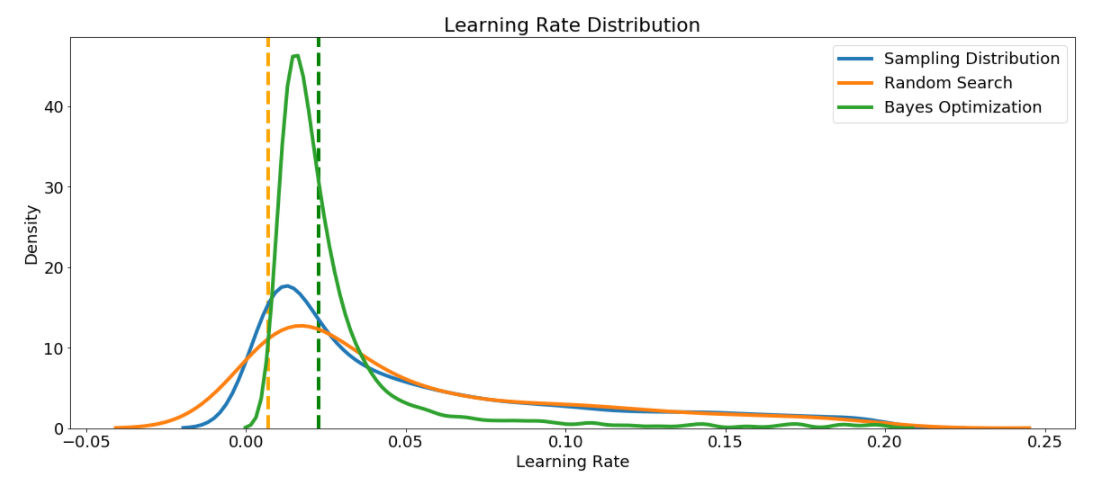

\
#### **- Hyperparameter is "the boosting type"**

  -  random search does not pay attention to past results, \
  we would expect each boosting type to be used roughly the same number of times.

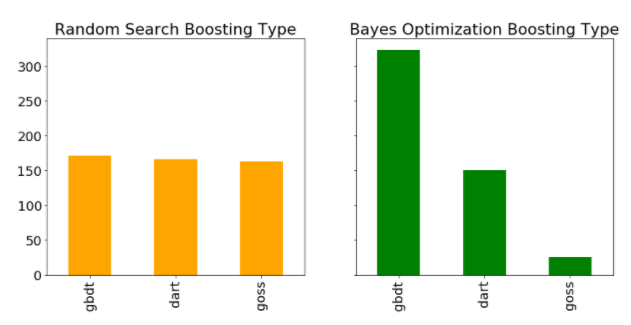

#### **- All of the numeric hyperparmeters**

- The vertical lines indicate the best value of the hyperparameter for each search

- In most cases (except for the subsample_for_bin ) \
the Bayesian optimization search tends to concentrate (place more probability) near the hyperparameter values \
that yield the lowest loss in cross validation. 

- This shows the fundamental idea of hyperparameter tuning using Bayesian methods\
: spend more time evaluating promising hyperparameter values.


- Interesting results here that might help us in the future when it comes time to define a domain space to search over. 
  - it looks like reg_alpha and reg_lambda should complement one another
  - if one is high (close to 1.0), the other should be lower.

- There’s no guarantee this will hold across problems, \
but by studying the results, we can gain insights that might be applied to future machine learning problems!


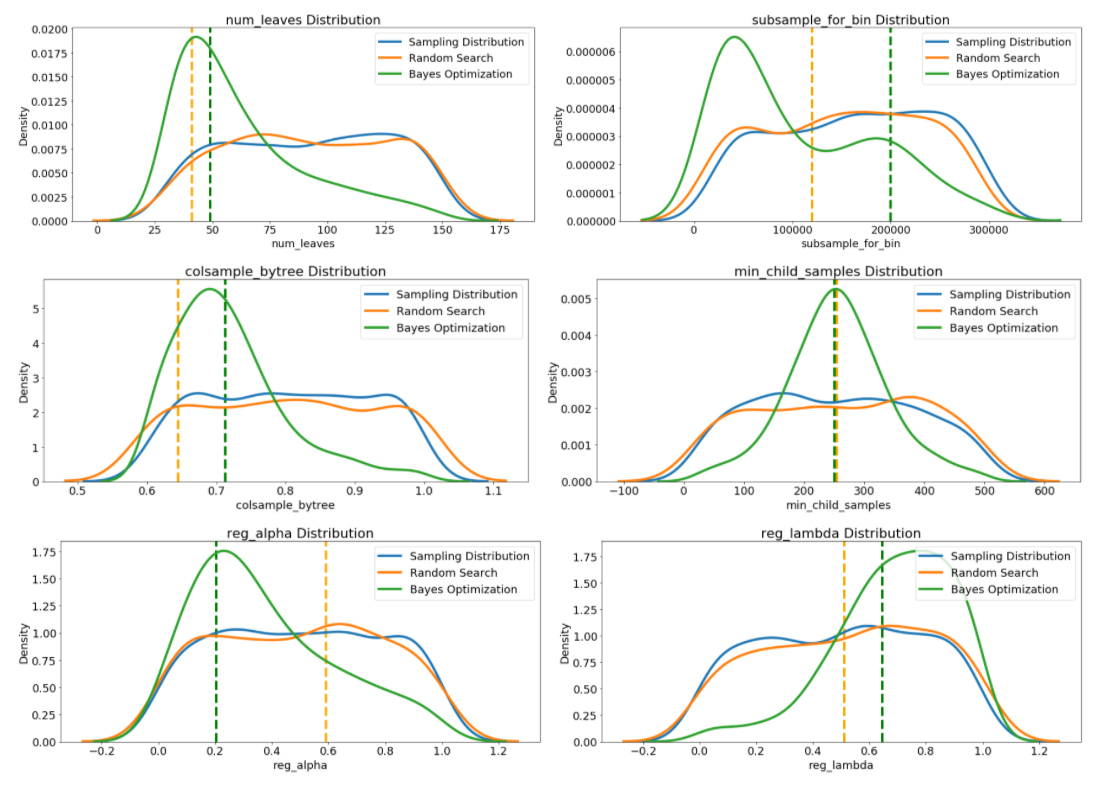

#### **- Evolution of Search**

- As the optimization progresses, we expect the Bayes method to focus on the more promising values of the hyperparameters \
: yield the lowest error in cross validation. 

- We can plot the values of the hyperparameters versus the iteration to see if there are noticeable trends.

- The black star indicates the optimal value. 

  - The colsample_bytree and learning_rate decrease over time \
  which could guide us in future searches.

- Finally, if Bayes Optimization is working, we would expect the average validation score to increase over time \
(conversely the loss decreases):

  - The validation scores from Bayesian hyperparameter optimization increase over time, \
  indicating the method is trying “better” hyperparameter values \
  (it should be noted that these are only better according to the validation score). 
  
  - Random search does not show an improvement over the iterations.



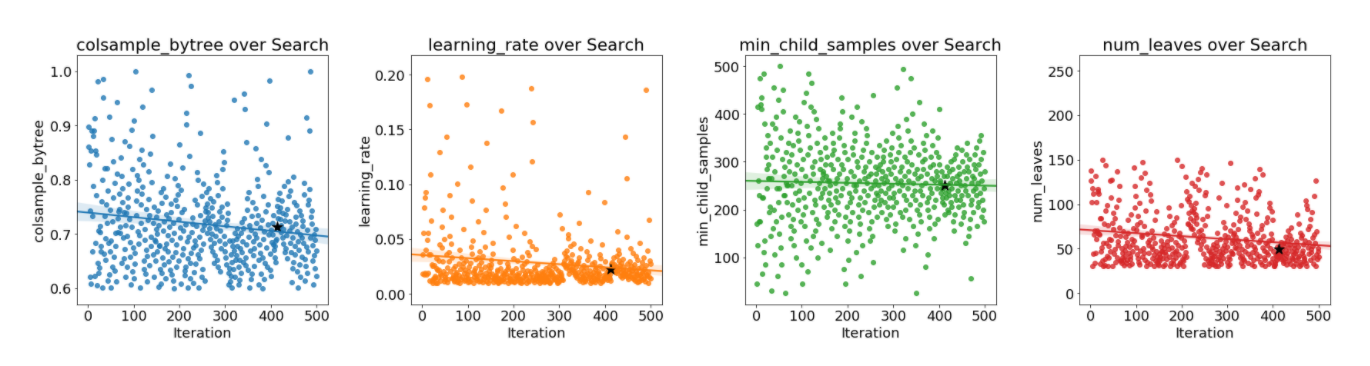

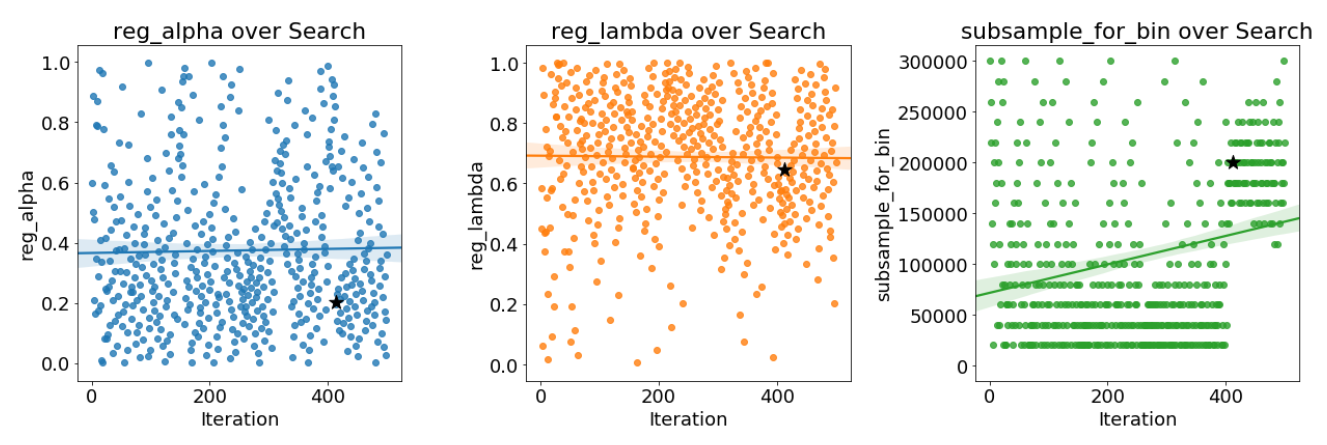

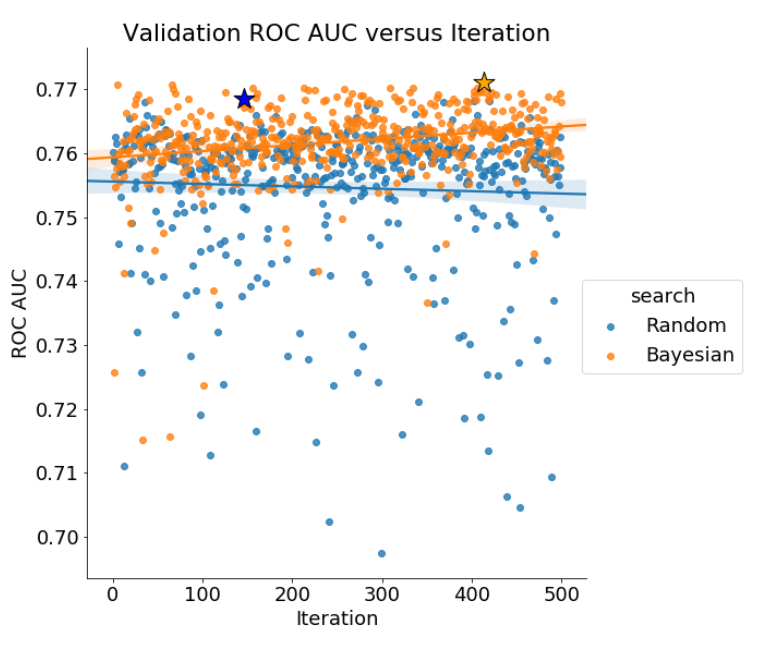

#### **- Continue Searching**

- If we are not satisfied with the performance of our model, \
we can keep searching using Hyperopt from where we left off. 

- We just need to pass in the same trials object and the algorithm will continue searching.

- As the algorithm progresses, \
more exploitation — picking values that have done well in the past\
less exploration — picking new values. 

- Instead of continuing where the search left off, \
it might therefore be a good idea to start an entirely different search. 

- If the best hyperparameters from the first search really are “optimal”, \
we would expect subsequent searches to focus on the same values. 

- Given the high dimensionality of the problem, and the complex interactions between hyperparameters, \
it’s unlikely that another search would result in a similar set of hyperparameters.

- After another 500 iterations of training, the final model scores 0.72736 ROC AUCon the test set. 
  - We really should not have evaluated the first model on the test set \
  and instead relied only on validation scores. 
  - The test set should ideally be used only once to get a measure of algorithm performance \
  when deployed on new data.

- Again, this problem may have diminishing returns to further hyperparameter optimization \
because of the small size of the dataset and there will eventually be a plateau in validation error 
  - there is an inherent limit to the performance of any model on a dataset\
   because of hidden variables that are not measured and noisy data, referred to as Bayes’ Error.

### **● Conclusions**

- In contrast to random search, Bayesian optimization chooses the next hyperparameters in an informed method \
to spend more time evaluating promising values. 

- The end outcome can be fewer evaluations of the objective function \
and better generalization performance on the test set compared to random or grid search.

- We were able to improve the test set performance of a Gradient Boosting Machine \
beyond both the baseline and random search although we need to be cautious of overfitting to the training data. 

- Using the four parts of an optimization problem, \
we can use Hyperopt to solve a wide variety of problems. 

- Making the switch from manual to random or grid search is one small step, \
but to take your machine learning to the next level requires some automated form of hyperparameter tuning. 

- Bayesian Optimization is one approach that is both easy to use in Python \
and can return better results than random search. 